In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from pyod.models.knn import KNN
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pycaret.regression import compare_models, setup

In [64]:
# Constants + Config
pd.set_option('display.max_columns', None)
shap.initjs()
%matplotlib inline

RANDOM_STATE = 42
N_JOBS = -1
DATA_PATH = 'loans_full_schema.csv'

In [3]:
# Load Dataset
df = pd.read_csv(DATA_PATH)
print(df.shape)

(10000, 55)


In [4]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,NaN,2008,7,22,16,69839,52722,0,0,NaN,0,0,1,6,4.0,16,0.0,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [5]:
# Quickly see a full Data Profile
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='DataFrame Report')
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='DataFrame Report')
html_profile = profile.to_html()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import pickle

with open("pandas_profile.pkl", "wb") as fp:
    pickle.dump(html_profile, fp)

# Clean Dataset

In [6]:
# Drop useless columns
to_drop = [
    'num_accounts_120d_past_due', # constant
    'emp_title', #high cardinality (we can fix that)
    'current_accounts_delinq', # 99% same
    'num_accounts_30d_past_due', # 99% same
    'paid_late_fees', # 99% same
    'annual_income_joint', # 85% missing, continuous, cant be fixed easily
    'debt_to_income_joint', # 85% missing, continuous, cant be fixed easily
    'months_since_90d_late', # 75% missing
    'months_since_last_delinq', # 50% missing
]
df['verification_income_joint'] = df['verification_income_joint'].replace(np.nan, 'Missing') #85% missing, discrete, can be turned into a new category
df = df.drop(to_drop, axis=1)

In [5]:
# Almost constant variable, 97.5% same.
df['tax_liens'].value_counts()

0     9754
1      165
2       48
3       18
4        7
5        5
7        1
52       1
6        1
Name: tax_liens, dtype: int64

In [11]:
df.describe()

,emp_length,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest
count,9183.000000,1.000000e+04,9976.000000,10000.00000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,8729.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,0.21600,2001.29000,1.95820,22.679600,11.40440,1.836062e+05,51049.063100,0.013800,0.167100,184.334000,2.663600,4.376100,7.340703,11.379600,3.595300,27357.410300,13.030000,8.095000,5.230500,1.383100,94.648990,0.043300,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781
std,3.703734,6.473429e+04,15.004851,0.68366,7.79551,2.38013,11.885439,5.86828,1.876327e+05,53636.731172,0.126535,0.687768,2206.389859,2.935387,3.158583,5.981590,5.859705,2.434689,26570.164081,7.874713,4.906606,3.327623,1.717274,9.155059,0.593852,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062
min,0.000000,0.000000e+00,0.000000,0.00000,1963.00000,0.00000,2.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,14.300000,0.000000,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.500000e+04,11.057500,0.00000,1997.00000,0.00000,14.000000,7.00000,5.159375e+04,19185.500000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,7.000000,2.000000,10000.000000,7.000000,5.000000,3.000000,0.000000,92.600000,0.000000,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500
50%,6.000000,6.500000e+04,17.570000,0.00000,2003.00000,1.00000,21.000000,10.00000,1.146670e+05,36927.000000,0.000000,0.000000,0.000000,2.000000,4.000000,6.000000,10.000000,3.000000,19500.000000,11.000000,7.000000,5.000000,1.000000,100.000000,0.000000,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000
75%,10.000000,9.500000e+04,25.002500,0.00000,2006.00000,3.00000,29.000000,14.00000,2.675500e+05,65421.000000,0.000000,0.000000,0.000000,3.000000,6.000000,11.000000,14.000000,5.000000,36100.000000,17.000000,10.000000,7.000000,2.000000,100.000000,0.000000,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000
max,10.000000,2.300000e+06,469.090000,13.00000,2015.00000,29.00000,87.000000,51.00000,3.386034e+06,942456.000000,3.000000,52.000000,199308.000000,35.000000,29.000000,24.000000,51.000000,32.000000,386700.000000,66.000000,46.000000,43.000000,14.000000,100.000000,52.000000,3.000000,40000.000000,60.000000,30.940000,1566.590000,40000.000000,41630.443684,40000.000000,4216.440000


#  Correlation

<AxesSubplot: >

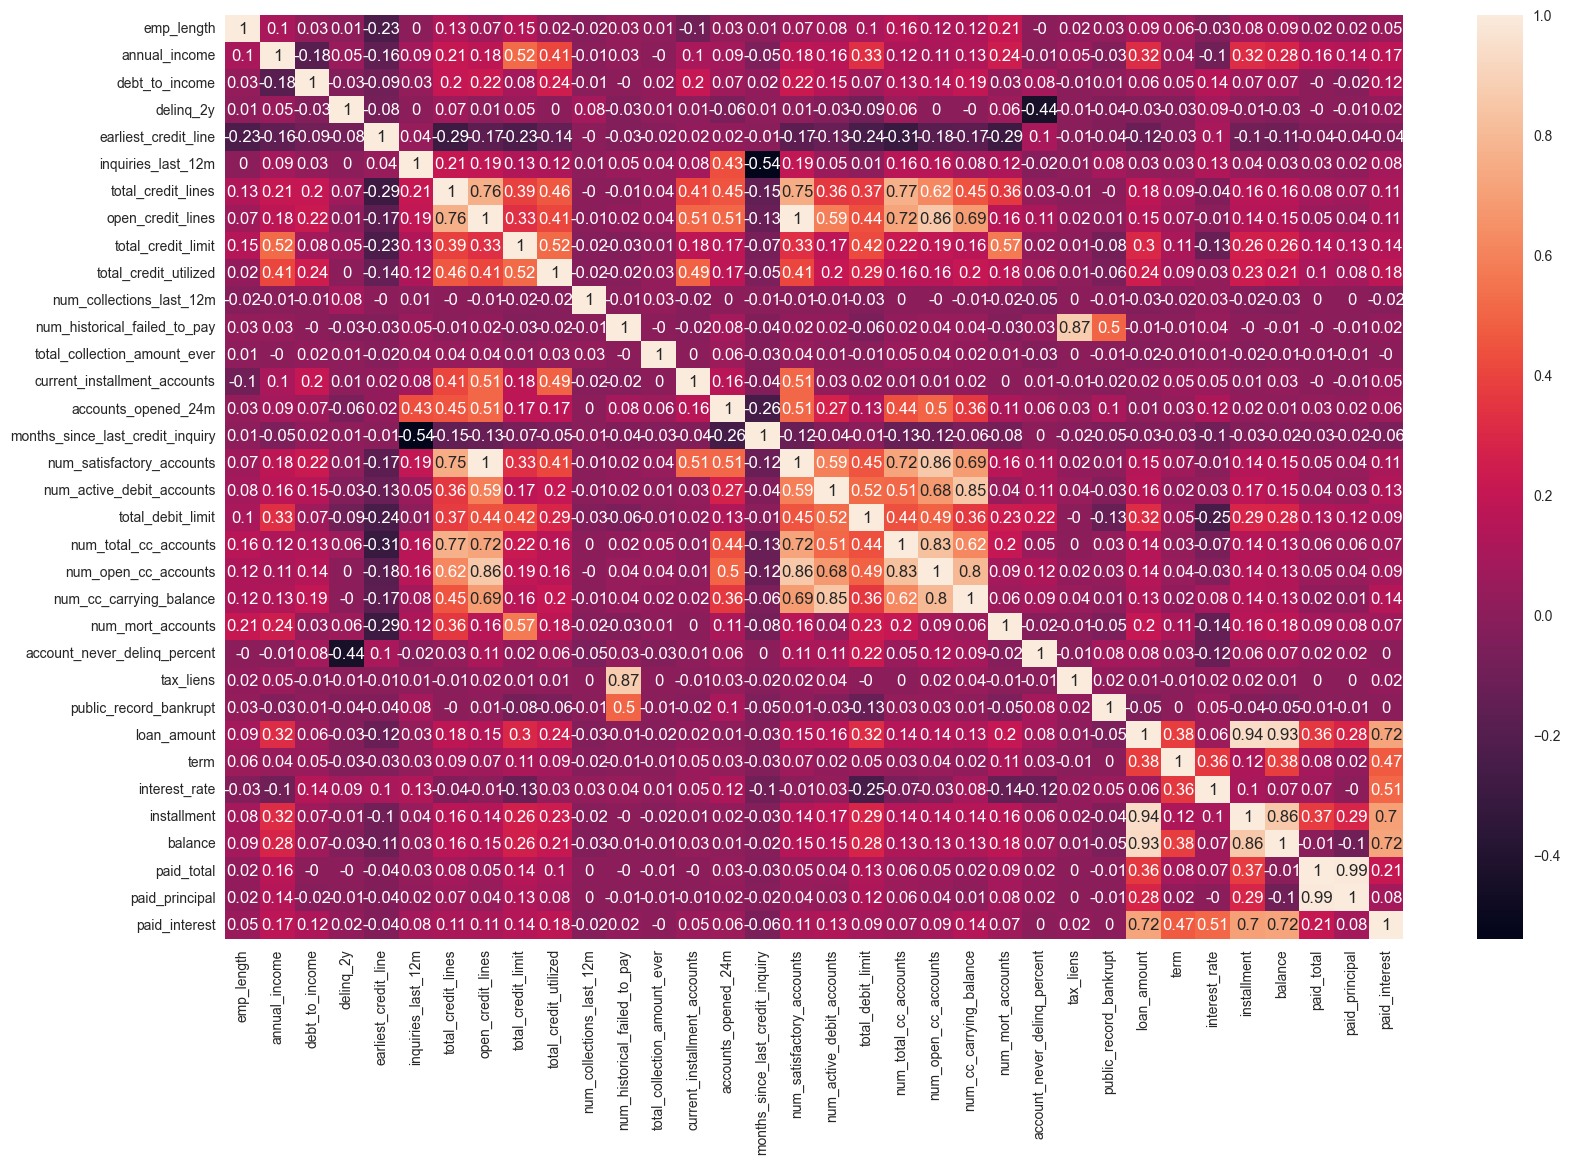

In [91]:
fig, ax = plt.subplots(figsize=(19, 12))
heatmap(round(df.corr(), 2), annot=True, ax=ax)

In [9]:
# Create a correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
# df = df.drop(df[to_drop], axis=1)

print(f'Dropped columns: {to_drop}')

Dropped columns: ['num_satisfactory_accounts', 'installment', 'balance', 'paid_principal']


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


After closer inspection, even though these variables have high correlation on certain features, they may actually hold really valueable information and I decided not to drop them. Of course this requires further investigation and testing

# Train Test Split

In [7]:
# Shuffle the data
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_size = int(len(df) * 0.75)
val_size = int(len(df) * 0.10)
test_size = int(len(df) * 0.15)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

x_train = train_df.drop('interest_rate', axis=1)
y_train = train_df['interest_rate']
x_val = val_df.drop('interest_rate', axis=1)
y_val = val_df['interest_rate']
x_test = test_df.drop('interest_rate', axis=1)
y_test = test_df['interest_rate']

Train test split must be used in order to validate that our model generalizes well.
In addition, we need to create the split before the scaling and the encoding, to have realistic results and simulate real world evaluation

# Feature Engineering

In [ ]:
# If I had more time I would consider creating some new features by combining some of the features already present in our dataset.

# Encoding Categorical Variables

In [8]:
# We use the binary encoder to make create less columns while trying to retain as much information as possible
from category_encoders import BinaryEncoder

print(len(df.columns)) #46

encoder = BinaryEncoder()
encoder.fit(x_train)
x_train = encoder.transform(x_train)
x_val = encoder.transform(x_val)
x_test = encoder.transform(x_test)
print(len(x_train.columns)) #70


46
70


# Handle NA's

In [18]:
# Visualize NA's distribution

def na_dist_viz(df : pd.DataFrame):
    missing = df.isnull().sum() > 0
    print(
        'Above 0 NA\'s in dataset are : \n',
        df.isnull().sum()[missing]
          )
na_dist_viz(df)

Above 0 NA's in dataset are : 
 emp_length                           817
debt_to_income                        24
months_since_last_credit_inquiry    1271
dtype: int64


In [9]:
feature_names = x_train.columns

imputer = SimpleImputer()
imputer.fit(x_train)
x_train = imputer.transform(x_train)
x_val = imputer.transform(x_val)
x_test = imputer.transform(x_test)

x_train = pd.DataFrame(x_train, columns = feature_names)
x_val = pd.DataFrame(x_val, columns= feature_names)
x_test = pd.DataFrame(x_test, columns = feature_names)

# Scaling

In [10]:
from sklearn.preprocessing import StandardScaler

feature_names = x_train.columns

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train = pd.DataFrame(x_train, columns = feature_names)
x_val = pd.DataFrame(x_val, columns=feature_names)
x_test = pd.DataFrame(x_test, columns = feature_names)

# Feature Selection

In [ ]:
# RFE ?

# Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df.columns

Index(['emp_length', 'state', 'homeownership', 'annual_income',
       'verified_income', 'debt_to_income', 'verification_income_joint',
       'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m',
       'total_credit_lines', 'open_credit_lines', 'total_credit_limit',
       'total_credit_utilized', 'num_collections_last_12m',
       'num_historical_failed_to_pay', 'total_collection_amount_ever',
       'current_installment_accounts', 'accounts_opened_24m',
       'months_since_last_credit_inquiry', 'num_satisfactory_accounts',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_purpose', 'application_type', 'loan_amount', 'term',
       'interest_rate', 'installment', 'grade', 'sub_grade', 'issue_month',
       'loan_status', 'initial_listing_status', 'disbursement_method',
 

In [44]:
sns.set_style("whitegrid", {'axes.grid': True})

Text(0.5, 1.0, 'Interest Rate - Grade')

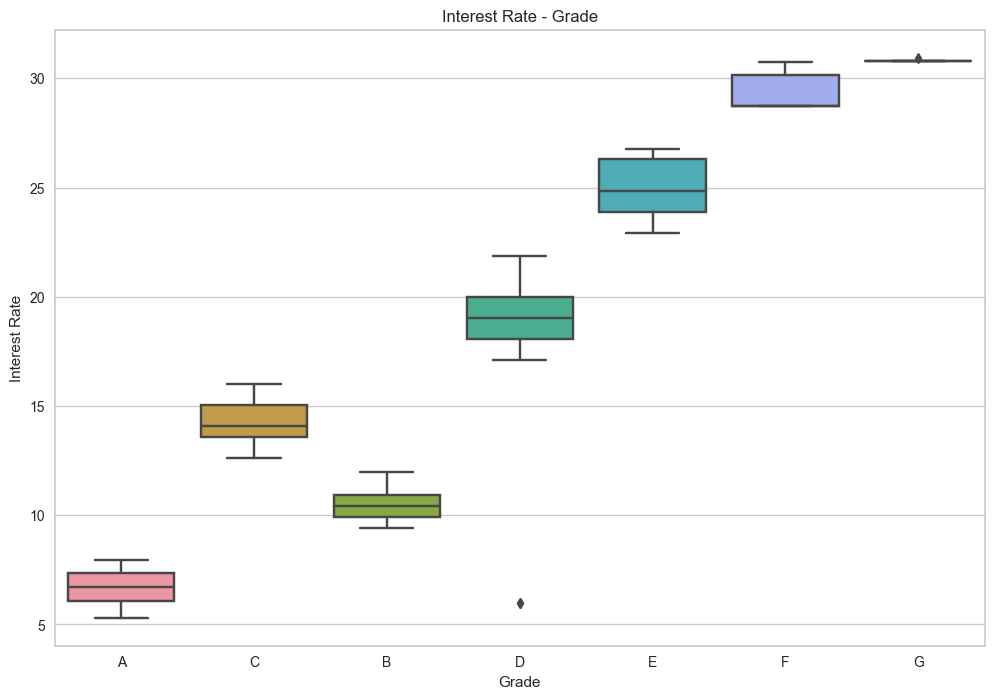

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))


sns.boxplot(data=df, x='grade', y='interest_rate', ax=ax)

ax.set_xlabel('Grade')
ax.set_ylabel('Interest Rate')
ax.set_title('Interest Rate - Grade')

# What is grade

Text(0, 0.5, 'Interest Rate')

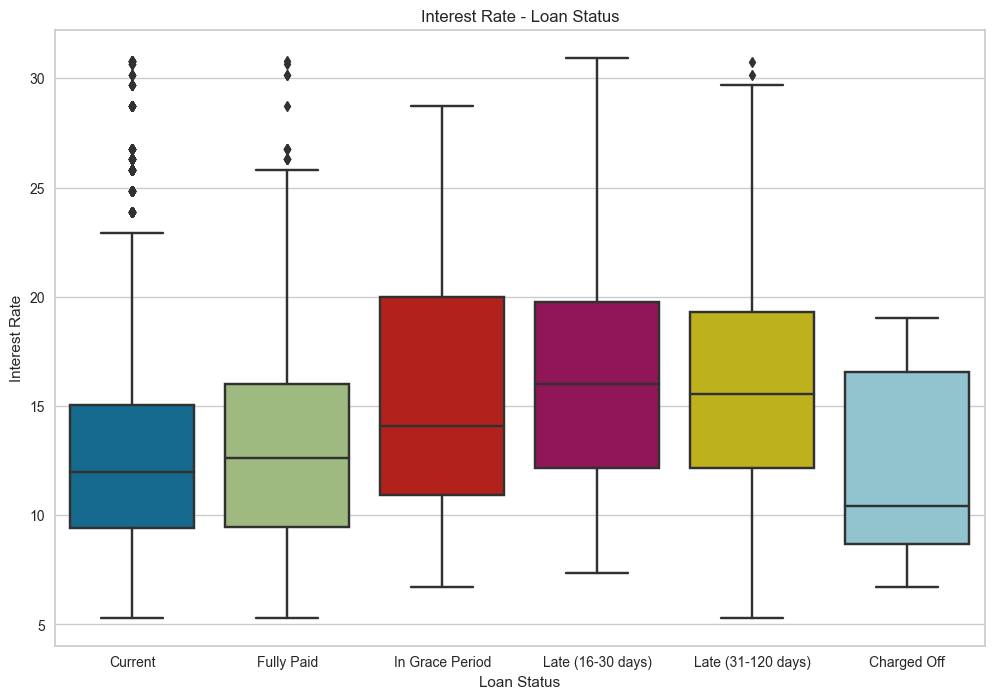

In [46]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(data=df, x='loan_status', y='interest_rate', ax=ax)

ax.set_title('Interest Rate - Loan Status')
ax.set_xlabel('Loan Status')
ax.set_ylabel('Interest Rate')

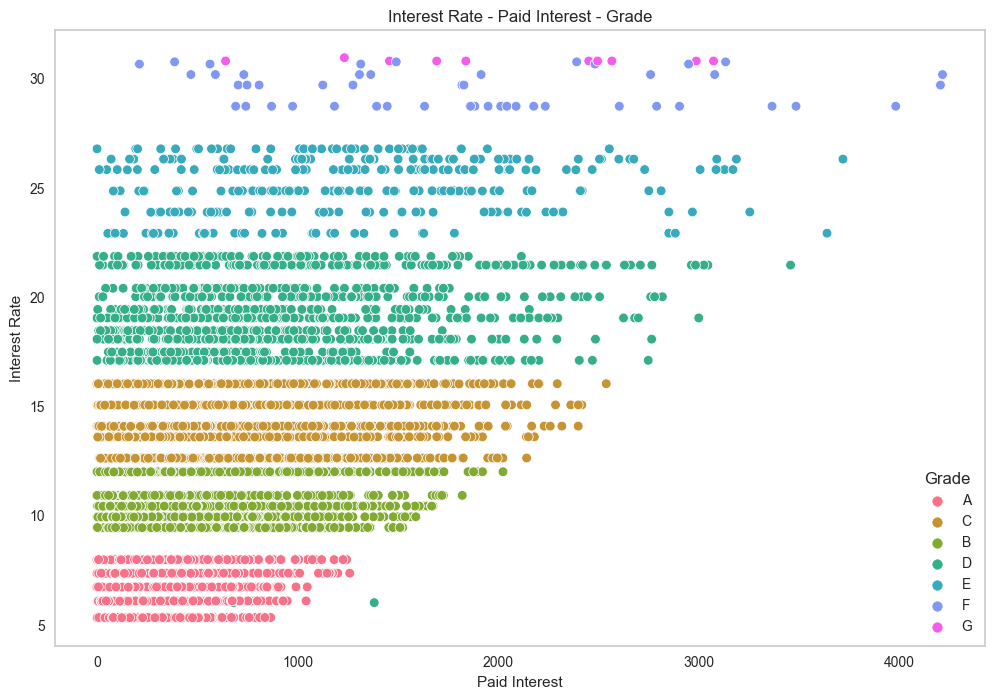

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(data=df, x='paid_interest', y='interest_rate', hue='grade', ax=ax)

ax.set_title('Interest Rate - Paid Interest - Grade')
ax.set_xlabel('Paid Interest')
ax.set_ylabel('Interest Rate')
ax.legend(title='Grade')
ax.grid(False)

In [29]:
grade_means=[]
for grade in df['grade'].unique():
    grade_means.append(df[df['grade'] == grade]['interest_rate'].mean())

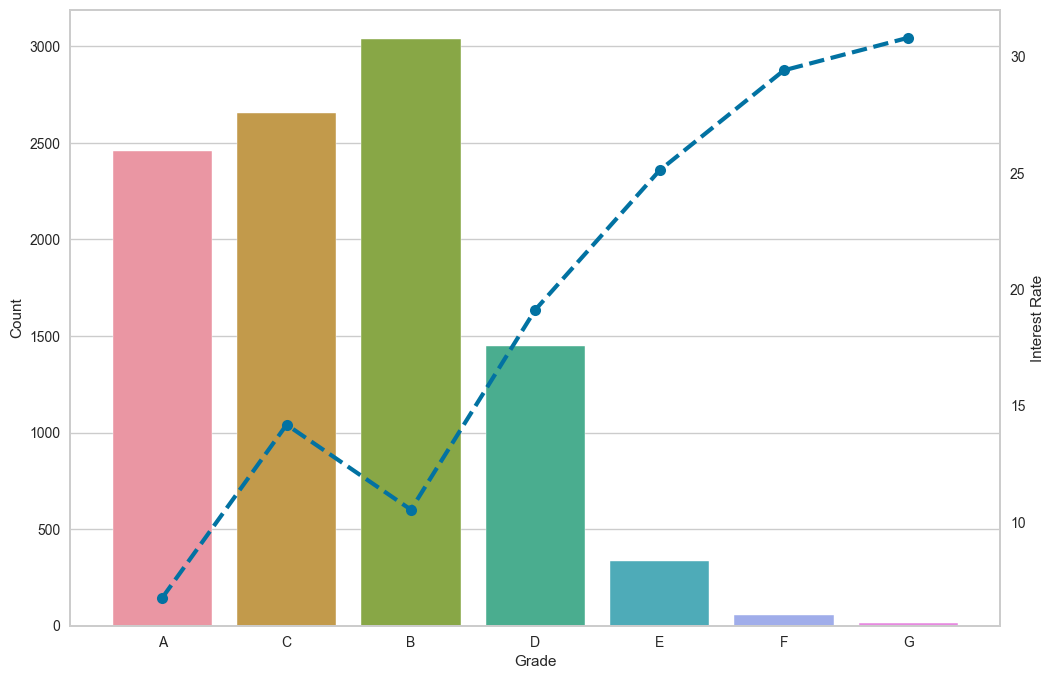

In [48]:
# Categorical Variable with Count on y Axis and then interest rate on 3rd axis as a line

fig, ax = plt.subplots(figsize=(12,8))

ax1 = sns.countplot(data=df, x='grade', ax=ax)
ax1.set_xlabel('Grade')
ax1.set_ylabel('Count')

ax2 = ax1.twinx()
p2 = ax2.plot(df['grade'].unique(), grade_means, linewidth=3, markersize=8, linestyle='--', marker='o')
ax2.set_ylabel('Interest Rate')
ax2.grid(False)


# Outlier Detection

Outlier detection plays a really important role in Machine Learning and can help improve the performance of a Regression Model greatly. In order to be effective though one has to consider many aspects, such as why some features take extreme values and if it is normal, so as to determine if the observations are worth dropping. With this limited time we can't really investigate further so we will just incorporate the outlier scores for now and give an explanation on a random sample of an outlier.

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parall

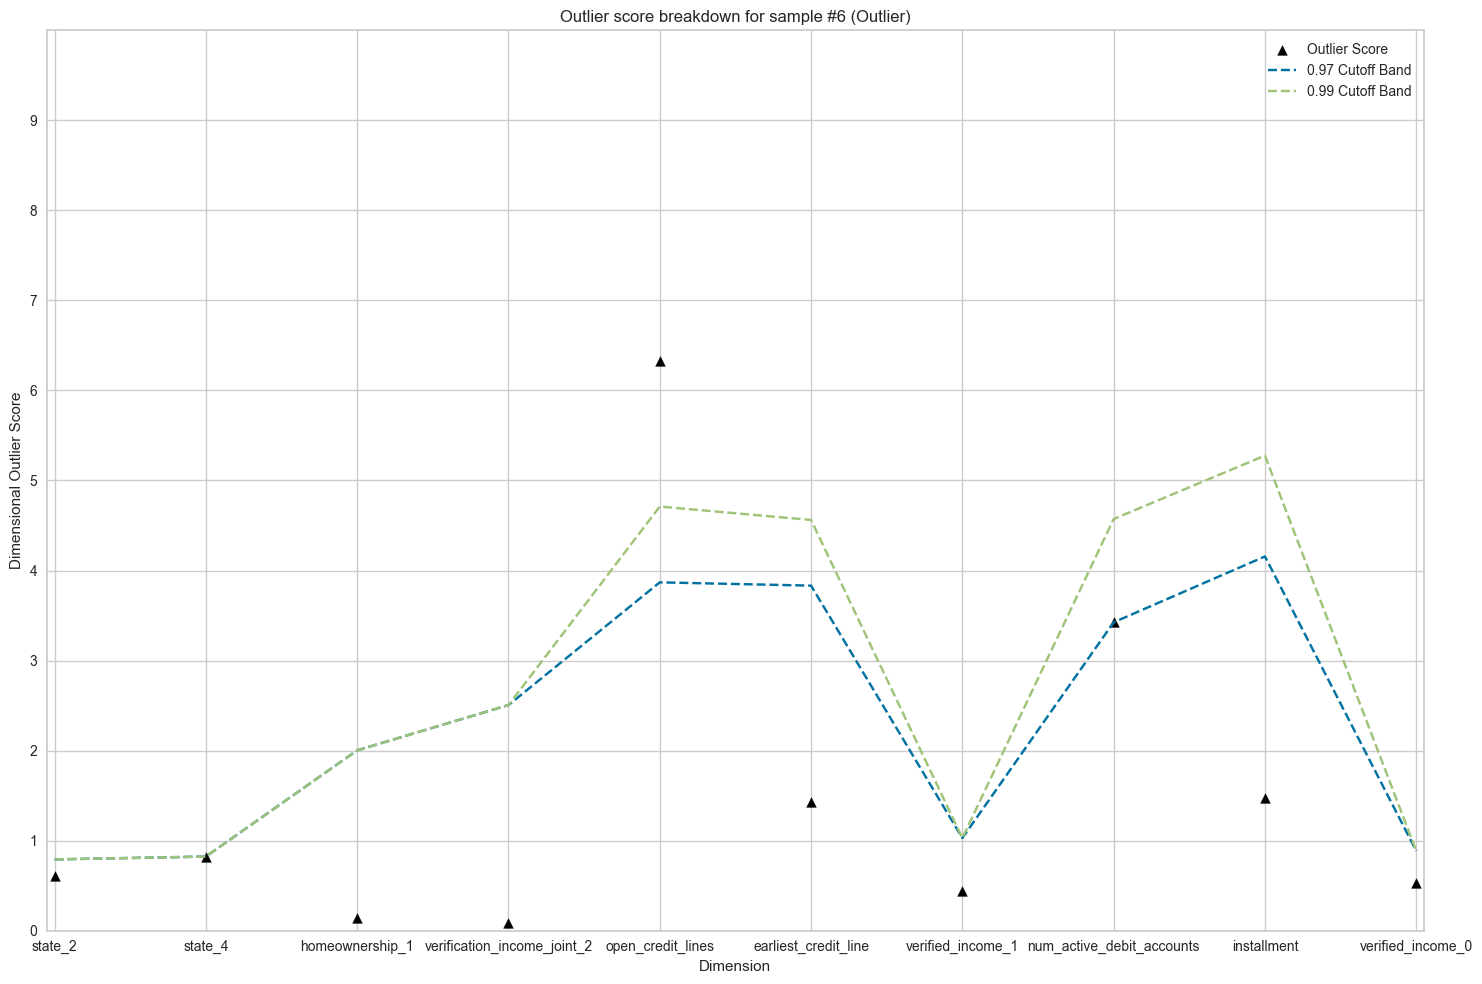

In [42]:
ecod = ECOD(contamination= 0.03, n_jobs=N_JOBS)
ecod.fit(x_train)

# predict raw anomaly score
outlier_scores_train = ecod.decision_function(x_train)
outlier_scores_val = ecod.decision_function(x_val)
outlier_scores_test = ecod.decision_function(x_test)

# prediction of a datapoint category outlier or inlier
outlier_labels_train = ecod.labels_
outlier_labels_val = ecod.predict(x_val)
outlier_labels_test = ecod.predict(x_test)

plt.rcParams['figure.figsize'] = [15, 10]
ecod.explain_outlier(ind=5, columns=[3,5,8,15,20,17,11,30,47, 10], feature_names=x_train.columns[[3,5,8,15,20,17,11,30,47,10]])

In [49]:
outlier_scores_test.reshape(-1, 1).shape

(1500, 1)

In [51]:
# Scale this new feature again and incorporate into the dataset

scaler_outlier = StandardScaler()
scaler_outlier.fit(outlier_scores_train.reshape(-1, 1))

x_train['outlier_score'] = scaler_outlier.transform(
    outlier_scores_train.reshape(-1, 1))
x_val['outlier_score'] = scaler_outlier.transform(
    outlier_scores_val.reshape(-1, 1))
x_test['outlier_score'] = scaler_outlier.transform(
    outlier_scores_test.reshape(-1, 1))


# Modeling

In [52]:
# We will keep the setup pretty simple cause we have already done most of the job

exp_v1 = setup(data = train_df, test_data = val_df, target='interest_rate')

,Description,Value
0,session_id,7394
1,Target,interest_rate
2,Original Data,"(7500, 46)"
3,Missing Values,True
4,Numeric Features,25
5,Categorical Features,19
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(7500, 210)"


In [53]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0494,0.0326,0.1211,0.9985,0.0080,0.0038,0.1190
lightgbm,Light Gradient Boosting Machine,0.0234,0.0331,0.1203,0.9985,0.0070,0.0015,0.0850
rf,Random Forest Regressor,0.0146,0.0343,0.1235,0.9984,0.0076,0.0010,1.4330
et,Extra Trees Regressor,0.0139,0.0464,0.1497,0.9979,0.0093,0.0010,1.3730
ridge,Ridge Regression,0.0818,0.0518,0.1723,0.9977,0.0118,0.0068,0.0350
gbr,Gradient Boosting Regressor,0.1466,0.0572,0.2135,0.9975,0.0158,0.0128,0.7330
omp,Orthogonal Matching Pursuit,0.1383,0.0712,0.2462,0.9969,0.0190,0.0120,0.0260
dt,Decision Tree Regressor,0.0145,0.0844,0.1949,0.9963,0.0140,0.0010,0.0570
lr,Linear Regression,0.7659,1.1935,1.0878,0.9513,0.0969,0.0700,0.5510
ada,AdaBoost Regressor,1.0494,2.3987,1.5371,0.9041,0.0946,0.0805,0.7040


In [67]:
best_model

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

LGB and RF are top performers, but best is Bayesian Ridge. 
We achive really good performance which leads us to think that there is data leakage somewhere.

In [61]:
# Random Forest Regressor

rf_reg = RandomForestRegressor(random_state = RANDOM_STATE, n_jobs = N_JOBS)
rf_reg.fit(x_train, y_train)
y_pred_train = rf_reg.predict(x_train)
y_pred_val = rf_reg.predict(x_val)

# Compure Metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

metrics_df = pd.DataFrame({
    'mse_train' : [mse_train],
    'mse_val' : [mse_val],
    'mae_train' : [mae_train],
    'mae_val' : [mae_val],
    'r2_train' : [r2_train],
    'r2_val' : [r2_val]
})
print('The metrics of the Random Forest Regresor are: \n', metrics_df)

The metrics of the Random Forest Regresor are: 
    mse_train  mse_val  mae_train  mae_val  r2_train    r2_val
0    0.01032  0.00706   0.007749  0.01208  0.999596  0.999708


In [62]:
import pickle

with open("rf_metrics_table.pkl", "wb") as fp:
    pickle.dump(metrics_df, fp)


# Model Tuning

In [63]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

def objective(search_space):
    model = RandomForestRegressor(
        **search_space,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
)
    model.fit(x_train, y_train)
    y_pred_val = model.predict(x_val)
    mse = mean_squared_error(y_val, y_pred_val)
    return {'loss': mse, 'status': STATUS_OK}

search_space={
    'n_estimators':hp.randint('n_estimators',200,1000),
    'max_depth': hp.randint('max_depth',10,200),                   
    'min_samples_split':hp.uniform('min_samples_split',0,1),   
    'min_samples_leaf':hp.randint('min_samples_leaf',1,10),          
    'criterion':hp.choice('criterion',['mse','mae']),
    'max_features':hp.choice('max_features',['sqrt', 'log2'])
}
algorithm = tpe.suggest

best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  rstate=RANDOM_STATE,
  max_evals=200)
print(best_params)

100%|██████████| 200/200 [42:45<00:00, 12.83s/trial, best loss: 0.8518762740541995] 
{'criterion': 0, 'max_depth': 137, 'max_features': 0, 'min_samples_leaf': 3, 'min_samples_split': 0.0006471075779693571, 'n_estimators': 243}


In [64]:
print(space_eval(search_space, best_params))
#best_params = space_eval(search_space, best_params)

{'criterion': 'mse', 'max_depth': 137, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.0006471075779693571, 'n_estimators': 243}


# Final Model Performance

In [54]:
# Create the model with the best params
rf_reg = RandomForestRegressor(
    **space_eval(search_space, best_params), random_state=RANDOM_STATE, n_jobs=N_JOBS)
rf_reg.fit(x_train, y_train)
y_pred_train = rf_reg.predict(x_train)
y_pred_test = rf_reg.predict(x_test)

# Compure Metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

metrics_df = pd.DataFrame({
    'mse_train': [mse_train],
    'mse_test': [mse_test],
    'mae_train': [mae_train],
    'mae_test': [mae_test],
    'r2_train': [r2_train],
    'r2_test': [r2_test]
})
print('The metrics of the BEST Random Forest Regresor are: \n', metrics_df)

The metrics of the BEST Random Forest Regresor are: 
    mse_train  mse_test  mae_train  mae_test  r2_train   r2_test
0   0.308589  0.693637    0.32047  0.521201  0.987915  0.969673


Unfortunately I didn't pick the hyperparameters really well and the tuned model is performing way worse than the original with the default settings. If I had more time I would choose the hyperparameter space more wisely.

# Feature Importance

Text(0, 0.5, 'Mean Decrease in Impurity (MDI)')

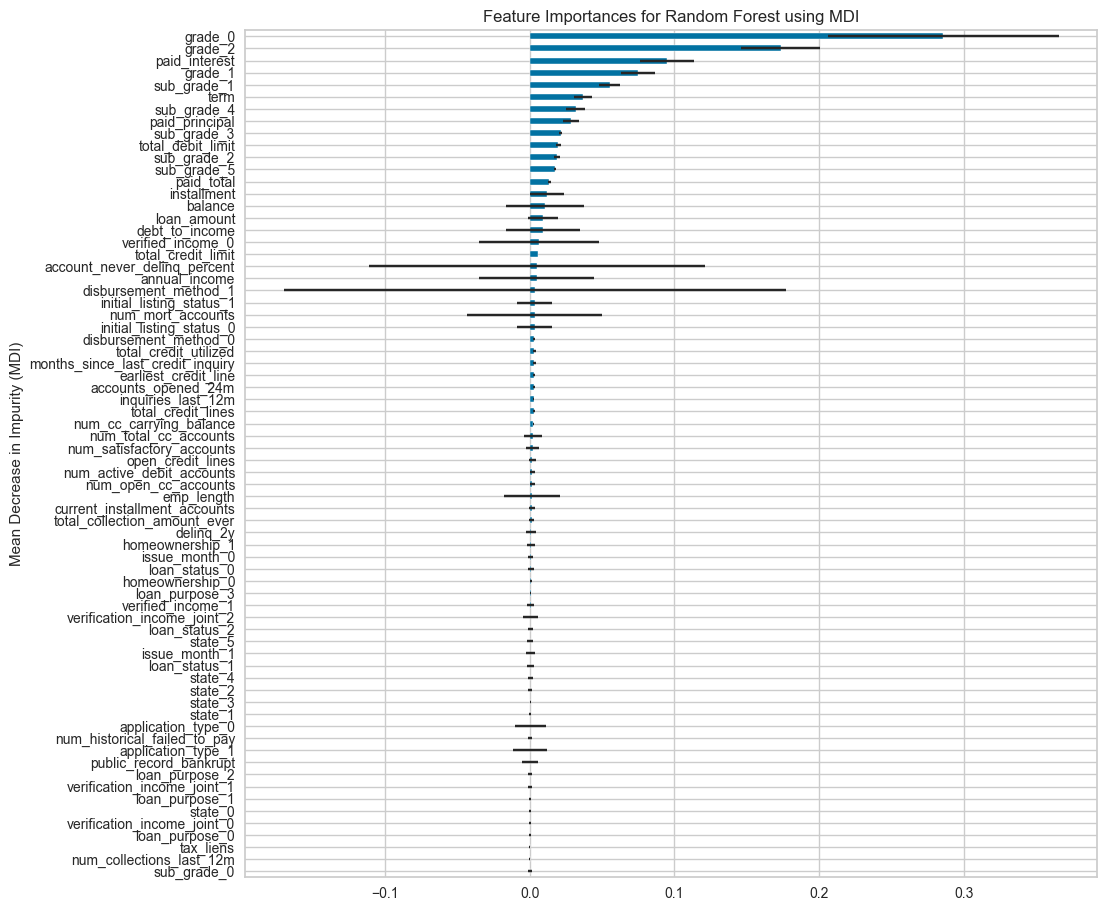

In [55]:
feature_names = x_train.columns

# Random Forest
importances_rf = pd.Series(rf_reg.feature_importances_, index=feature_names)
std_rf = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(11, 11))
importances_rf.sort_values(ascending=True).plot.barh(xerr=std_rf, ax=ax)
ax.set_title('Feature Importances for Random Forest using MDI')
ax.set_ylabel('Mean Decrease in Impurity (MDI)')

# black bars represent the std of the MDI

From the feature importance we can clearly see that only the first 3-4 variables are important to the model while the rest are not really informative

# Explanation

In [56]:
explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer.shap_values(x_test, y_test, check_additivity=True)
feature_names = x_test.columns

In [59]:
with open("shap_values.pkl", "wb") as fp:
    pickle.dump(shap_values, fp)

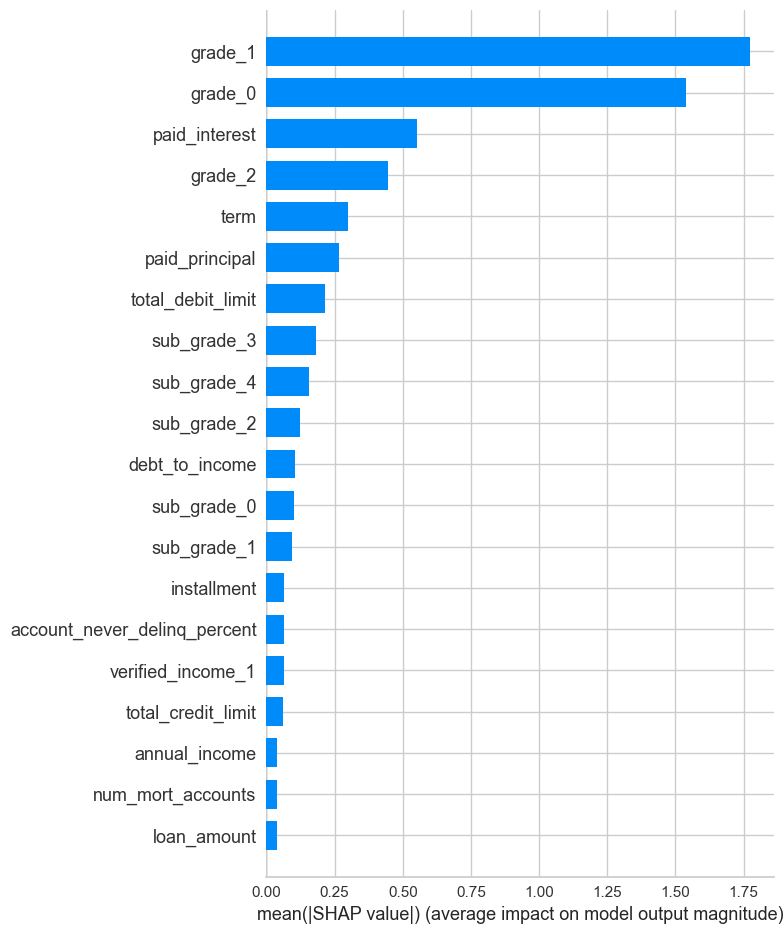

In [75]:
# Summary plot bar
shap.summary_plot(shap_values, x_test,
                  feature_names=feature_names, plot_type="bar")


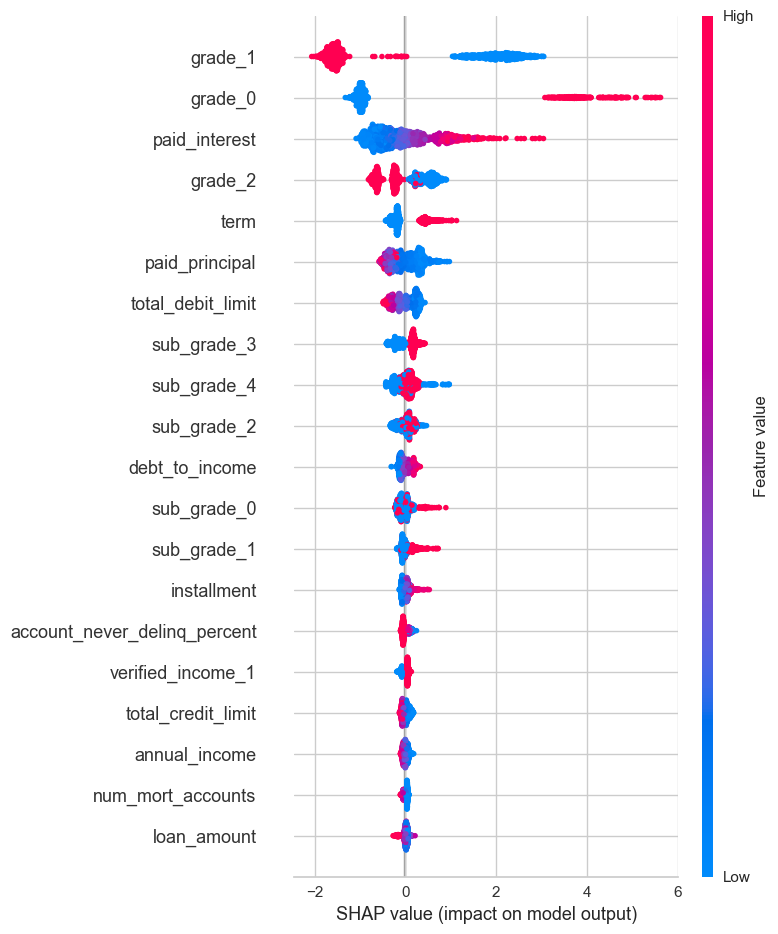

In [76]:
# Summary plot
shap.summary_plot(shap_values, x_test, feature_names=feature_names)

In [65]:
# Force plot
shap.force_plot(explainer.expected_value, shap_values[0], x_test.iloc[0])

# Bayesian Ridge Model

Surprised that a Linear model, even though bayesian, had such great results. We can just do a quick modelling to assess performance and look at the weights of the features

In [58]:
from sklearn.linear_model import BayesianRidge

bayes_ridge = BayesianRidge()
bayes_ridge.fit(x_train, y_train)

y_pred_test = bayes_ridge.predict(x_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

metrics_df = pd.DataFrame({
    'mse_test' : [mse_test],
    'mae_test' : [mae_test],
    'r2_test' : [r2_test]
})
print('Metrics of the Bayesian Ridge model in the Test set: \n', metrics_df)

Metrics of the Bayesian Ridge model in the Test set: 
    mse_test  mae_test   r2_test
0  1.810383  1.033856  0.920847


In [60]:
with open("ridge_metrics_table.pkl", "wb") as fp:
    pickle.dump(metrics_df, fp)

Evidently it is not better than the RandomForest Regressor. The difference in metrics may be due to different implementations ?

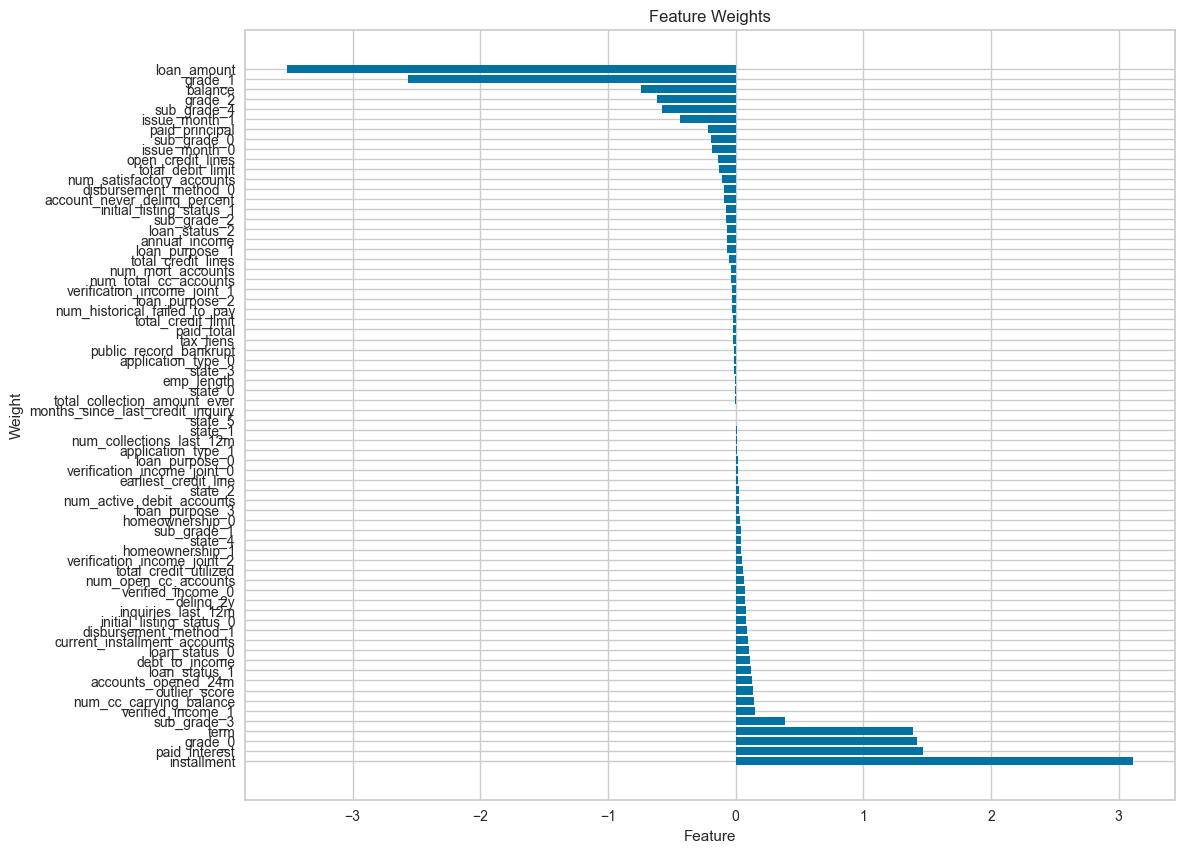

In [85]:
# The weights of the ridge model
weights = bayes_ridge.coef_

# Get the names of the features
feature_names = x_train.columns

# Sort everything
sorted_weights = sorted(weights, reverse=True)
sorted_feature_names = [feature_names[i] for i in np.argsort(weights)][::-1]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12,10))

# Plot the weights as a bar plot
ax.barh(sorted_feature_names, sorted_weights)

# Add axis labels and a title
ax.set_xlabel('Feature')
ax.set_ylabel('Weight')
ax.set_title('Feature Weights')

# Show the plot
plt.show()

In [ ]:
# Ideas

#AutoML with pycaret maybe?
#Feature importance, plot with stds as well
#XGBoost

#Correlations
#Correlations non linear
#Correlations of categorical

#Feature Selection

#Encoding with category encoders

#Auto scaling with pipeline and just standard scaler
#Explain that scaling doesn't matter for decision trees + add reference to research paper that they are the best for tabular data

#Anomaly detection with pyod + explanation ? (Ecod explain outlier maybe)

#Explain model with shap

#Include pandas-profiling html to the website